# Part 0: Introduction and Imports

This project guides you through the general pipeline used to build and train a convolutional neural network (CNN) for an image classification task. You'll be implementing data augmentation, improving upon a baseline model, and trying to fool your CNN with adversarial images.


We will be using a library called PyTorch which simplifies many of the low-level implementation details of neural networks for us, so that we can focus on the high-level deep learning concepts.

### New to Jupyter notebooks?
Check out this [quick video introduction](https://www.youtube.com/watch?v=jZ952vChhuI) to Jupyter notebooks before starting, and feel free to post on Piazza if you run into any issues.

### Using this notebook
This notebook will walk you through the different parts of the assignment, with detailed instructions and explanations at every step. You'll see red <font color="red">TODO [code]</font> for things you need to write in `student.py`, and red <font color="red">TODO [writeup]</font> for things you need to answer in your writeup. Please write the answers for <font color="red">TODO [writeup]</font> in the same document as the questions for image formation, camera calibration, and stereo.


### Your code
Once again, **all of your code needs to be written in `student.py`, and not in this notebook!** We will not grade any code written in this notebook (since you will not be submitting it); this notebook is meant to serve as a central tool that you can use to run your code and visualize your outputs. It also contains detailed explanations at every step to guide you. If anything is unclear, please post on Piazza!


### Python version
The top-right of this notebook should display a Python version; please make sure that it says Python 3 before proceeding!

In [2]:
%load_ext autoreload
%autoreload 1
%matplotlib inline
%aimport student
# Imports

import numpy as np
import sys
import os
from skimage import io
from datetime import datetime

import matplotlib
from matplotlib import pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets


# Constants
classes = [
     'bighorn-sheep',
     'bison',
     'black-stork',
     'brown-bear',
     'bullfrog',
     'camel',
     'gazelle',
     'golden-retriever',
     'goldfish',
     'ladybug',
     'lion',
     'orangutan',
     'penguin',
     'persian-cat',
     'pig',
     'puma'
]


# Part 1: Reading the data

### Step 1: Unpacking the dataset

Unzip the `data.zip` file. You should now have a folder called `data` with this structure:

```
data/
    train/
        bighorn-sheep/
            XXXX.JPEG
        goldfish/
            XXXX.JPEG
        ...
    val/
        bighorn-sheep/
            XXXX.JPEG
        goldfish/
            XXXX.JPEG
        ...
```

The names of the actual images (`XXXX.JPEG` in the diagram above) don't matter - only the folder structure matters, where the names of the folders under `train/` and `val/` correspond to the class names.

**Data summary:**
There are 16 classes, each with 500 training images and 50 validation images. Each image is 64x64 with 3 channels.

The classes are the following:
```
bighorn-sheep
bison
black-stork
brown-bear
bullfrog
camel
gazelle
golden-retriever
goldfish
ladybug
lion
orangutan
penguin
persian-cat
pig
puma
```


### Step 2: A quick sanity check...
Before training any machine learning model, it's important to fully understand the data that is being dealt with. What does it look like, and does it match our expectations? In this part, we'll run code that looks into the dataset and shows us what it contains.

To help with this, we have first defined a `show_image` function that takes an array as input and visualizes it as an image (as long as it is shaped like an image).

In [2]:
def show_image(data):
    '''
    Given an image-like array, plot it as an image.
    
    Parameters:
        data: a numpy array shaped like an image (could be RGB or grayscale)
    '''
    plt.imshow(data, interpolation='nearest')
    plt.show()

In [3]:
def get_N_images(N, class_name, root_folder):
    """
    Returns N images from [class_string] class under [root_folder]
    
    Inputs:
        N             scalar; number of images to return
        
        class_name    string; name of class to get images from.
                      Must be name of a folder under root_folder
                      where images of the class are held.
                      
        root_folder   string; relative path to folder containing subfolders
                      with image classes.
                      
                      Example structure:
                      root_folder/
                          class_x/
                              XXX.JPEG
    Returns:
        images        length N list of numpy arrays of images of class [class_name]
    """
    images = []
    for root, dir, files in os.walk(root_folder):
        if root.split(os.sep)[-1] == class_name:
            for i, file in enumerate(files):
                if file.endswith('.JPEG'):
                    images.append(plt.imread(os.path.join(root,file)))
                if i+1 == N:
                    return images


Visualizing class: pig


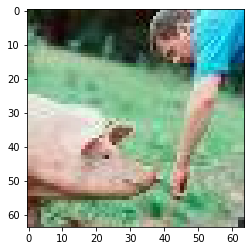

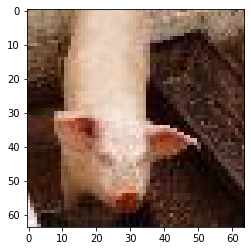

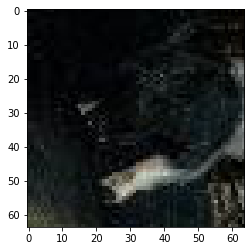

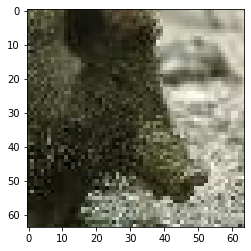

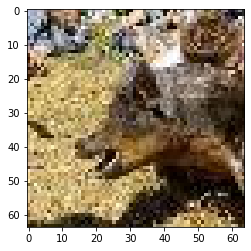

In [4]:
N = 5
class_name = 'pig'
folder     = os.path.join('.', 'data', 'train')
images     = get_N_images(N, class_name, folder)

print("Visualizing class: {}".format(class_name))
for i in range(N):
    show_image(images[i])

### Step 3: Normalize data

Normalizing the data means getting the features in a similar range of values. This is an important step in your CNN pipeline. Making the features (here, pixels) in a similar data distribution helps the model converge.

We've already looped through the training dataset and found the channel-wise means and standard deviations for you. We've divided them by 255, since the PyTorch Tensors have values between [0,1]. The images are normalized by subtracting the means and dividing by the standard deviations.  

PyTorch has an easy method for integrating normalization into your machine learning pipeline - you create 
[transforms](https://pytorch.org/docs/master/torchvision/transforms.html?highlight=transform), which are just different data manipulations you can chain together. Before you pass an image to your model, it's fed through the transform first.

The transform below converts the images into the correct format and then applies the normalization.

In [5]:
dataset_means = [123./255., 116./255.,  97./255.]
dataset_stds  = [ 54./255.,  53./255.,  52./255.]


transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(dataset_means, dataset_stds)
        ])

###  Create Dataset and DataLoader for PyTorch model
The model we will soon create in PyTorch needs a way of understanding our dataset folder structure.

This has 2 steps:

1. Define a **[Dataset](https://pytorch.org/docs/master/data.html#torch.utils.data.Dataset)**
    - Tells the model where your data is and how to access it
    - Requires `__getitem__` function, which tells your model how to grab an image and label when needed
    - Requires `__len__` function, which returns the size of the dataset
    
   &nbsp; 
2. Define a **[DataLoader](https://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader)**
    - Tells the model how to sample from the dataset
    - Defines the _batch size_, which is the number of images propagated through the network during one forward pass before a gradient update

Run the cell below to create a class `AnimalDataset` which implements the required functions.
Then, run the following cell to create a Dataset and DataLoader for both train and validation sets.

In [3]:
class AnimalDataset(Dataset):
    def __init__(self, root_dir, classes, transform=None):
        """
        Args:
            root_dir (string):
                Directory with all the images.
                Of the form:
                root_dir/
                    <class_XX>/
                        <XXXX>.JPEG
                        ...
                    <class_XX>/
                        <XXXX>.JPEG
                        ...
                where <class_XX> is replaced with the class name, and <XXXX>.JPEG
                are the images. Must be .JPEG extension.
                
            classes (list of strings): list of class names, same as names of
                subfolders under root_dir
                
            transform (callable, optional): Optional transform to be applied
                on a sample.
                
        """
        self.root_dir = root_dir
        self.classes = classes
        self.transform = transform

        self.raw_data = []
        for i, cl in enumerate(self.classes):
            for root, directory, files in os.walk(os.path.join(root_dir, cl)):
                for file in files:
                    if '.JPEG' in file:
                        self.raw_data.append((os.path.join(root, file), i))

    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self, idx):
        if type(idx) == torch.Tensor:
            idx = idx.item()
        
        image_path, label = (self.raw_data[idx])
        image = io.imread(image_path)
        image = self.transform(image)
        label = torch.tensor([label], dtype=torch.long)
        return image, label

In [7]:
BATCH_SIZE = 128

train_dataset = AnimalDataset(os.path.join('.', 'data', 'train'),classes, transform=transform)
val_dataset   = AnimalDataset(os.path.join('.', 'data', 'val'),  classes, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=True)

### **<font color='red'>TODO [writeup] 1: </font>** 
Why is it important to have separate train and validation sets? What might happen if you _don't_ have a validation set?

It is important to have separate train and validation sets because the model needs to be evaluated in some way, and so seeing how it does on a clean data set is essential. If the sets are not separate, then the validation set will be biased and the model will probably look better than it actually is. If you don't have a validation set at all, you will not be able to tell if your model does well on data it has never seen before.

# Part 2: Fitting the data

### High-Level Overview
Now, we will attempt to fit the data using a convolutional neural network. This network will learn to classify input images into one of the 16 animal categories, based on the training data that we provide to it. We will use our validation dataset to get a sense of how the network performs on unseen data.

### Create a baseline model
Below we have defined a baseline model, which you will improve on in a later part of this project. There are two parts to defining a model:

1. `__init__`: Define the **layers** of your network. Check out torch.nn documentation for pre-implemented layers.

    &nbsp;
2. `forward`: Chains together the layers you defined in `__init__`, creating the **pipeline** for a forward pass (i.e. where the image goes when you feed it to the network). In our baseline, the image passes through a series of **convolution** layers followed by **ReLU** (Rectified Linear Unit) nonlinearities, followed by a couple **fully connected** layers.

### **<font color='red'>TODO [code]: </font>** 

Implement the baseline model architecture in `student.py`. The architecture is the following:
- **conv1**: convolution layer with 6 output channels, kernel size of 3, stride of 2, padding of 1
- **ReLU** nonlinearity
- **conv2**: convolution layer with 12 output channels, kernel size of 3, stride of 2, padding of 1
- **ReLU** nonlinearity
- **conv3**: convolution layer with 24 output channels, kernel size of 3, stride of 2, padding of 1
- **ReLU** nonlinearity
- **fc**:    fully connected layer with 128 output features
- **ReLU** nonlinearity
- **cls**:   fully connected layer with 16 output features (the number of classes)



The feature map sizes in this case are calculated by dividing the input size by the _stride_ (how many pixels you slide the kernel over each time you do a convolution). For example, we started with a 64 x 64 image, passed it through the `conv1` layer with a stride of 2, giving an output size of 32 x 32. When you create your own model, it's important to pay attention to these sizes. You'll need to figure out the dimensions to the first Linear layer, which needs an input size equal to the number of pixels in your Tensor by that point in the network.


To verify that we added the correct layers above, we can **load the pretrained weights** into the architecture. The weights file essentially holds a dictionary, where the keys are the layer names and the values are the parameter weights. If your architecture is correct, you should be able to print the network and see the layers.

**Please define the forward pass manually rather than using nn.Sequential. Otherwise, the pretrained model weights won't load correctly.**

You'll have to create your own model, so make sure you understand the baseline architecture before proceeding!

In [9]:
%aimport student

net_pretrained = student.AnimalBaselineNet()

# Load pretrained weights into network to check if architecture is correct
weights_path = os.path.join('.', 'models', 'baseline.pth')
net_pretrained.load_state_dict(torch.load(weights_path, map_location="cpu"))

for layer in net_pretrained.children():
    print(layer)


Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
Conv2d(6, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
Conv2d(12, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
Linear(in_features=1536, out_features=128, bias=True)
Linear(in_features=128, out_features=16, bias=True)
ReLU()


###  Train the model

Great, we have our model and our data! There's two more steps before we can train:
- Decide what **loss function** you need. Here, we use [_cross entropy loss_](https://pytorch.org/docs/master/nn.html#crossentropyloss), typical for image classification.
- Decide how many **epochs** you will train your model for. One epoch means one pass of the full training dataset through your model. Here, we set it to 30. When you train your own model, you'll have to keep track of the losses to decide when to stop.
- Decide what **optimizer** you will use. An optimizer tells your model how to take steps along the gradient to try and reach a minimum. Here, we use the popular _Adam optimizer_ (if you're curious, here's the [paper](https://arxiv.org/pdf/1412.6980.pdf)). It adapts the learning rates for each parameter based on how quickly each parameter's gradient is changing. It's known as being more forgiving for less-than-optimal hyperparameter choices than other optimizers are.

We also redefine the network to start from scratch, rather than loading in pretrained weights.


In [9]:
%aimport student

net = student.AnimalBaselineNet()

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(net.parameters(), lr = 0.01)
epochs = 30

Time to train! For each epoch, the model does a forward and backward pass for training, and then just a forward pass for validation. But what are forward and backward passes?

- **Forward pass**: sends a batch of images through the network. Returns the output of the last linear layer, which has 16 values: each value is the negative log-likelihood that the image belongs to that particular class.
- **Backward pass**: calculates the loss and the gradient of the loss with respect to the model parameters. Optimizer updates the weights based on this gradient.

During training, we keep track of the loss and accuracy for both training & validation phases so we can visualize our model performance after it's done.

### **<font color='red'>TODO [code]: </font>** 
Implement the `model_train` function in `student.py`. We will be running your `model_train` with your `AnimalBaselineNet` to check accuracy.

### **<font color='red'>TODO [writeup] 2a: </font>** 
Include the plots generated from training the baseline model from scratch (i.e., without loading in pretrained weights). What do you notice about the train vs. validation performance? What might this mean about the model?


Both the average loss and the accuracy for the train and validation sets diverge in less than 5 epochs. This means that the model is overfitting and that the model is not very good. The model accuracy never gets above 25% for the validation set and loss increases linearly after 5 epochs for the validation set.


In [5]:
def log_progress(curr_batch, batch_size, curr_epoch, total_epochs, dataloader):
    """
    Prints message logging progress through training.
    """
    progress = float(curr_batch + 1)/(float(len(dataloader.dataset)) / batch_size)
    log = "EPOCH [{}/{}].Progress: {} % ".format(
        curr_epoch + 1, total_epochs, round(progress * 100, 2))
    sys.stdout.write("\r" + log)
    sys.stdout.flush()

In [11]:
%aimport student

# Keep track of average losses, training accuracy and validation accuracy for each epoch
train_loss_history = np.zeros(epochs)
train_acc_history  = np.zeros(epochs)
val_loss_history   = np.zeros(epochs)
val_acc_history    = np.zeros(epochs)

start_time = datetime.now()

for epoch in range(epochs):
    
     # ============================ Training ==============================
    print("Training...")
    
    # Place network in training mode
    net.train()
    
    # Initialize running epoch loss and number correctly classified
    running_loss   = 0.0
    num_correct    = 0.0
    total_images   = 0.0
    
    
    for batch_num, (inputs, labels) in enumerate(train_dataloader):
        # [inputs] and [labels] is one batch of images and their classes

        log_progress(batch_num, BATCH_SIZE, epoch, epochs, train_dataloader)
        
        # Function call to student
        curr_loss, curr_correct, curr_images = \
            student.model_train(net, inputs, labels, criterion, optimizer)
        running_loss += curr_loss
        num_correct += curr_correct
        total_images += curr_images

    # Update statistics for epoch
    train_loss_history[epoch] = running_loss / total_images
    train_acc_history[epoch]  = float(num_correct)  / float(total_images)
    print("\n Train Avg. Loss: [{}] Acc: {} on {} images\n".format(
          round(train_loss_history[epoch],4), train_acc_history[epoch], total_images) )
    
    # ============================ Validation ==============================
    print("Validating...")
    # Place network in testing mode (won't need to keep track of gradients)
    net.eval()
    
    running_loss   = 0.0
    num_correct    = 0.0
    total_images   = 0.0
    
    for batch_num, (inputs, labels) in enumerate(val_dataloader):
        
        # Propagate batch through network
        outputs  = net(inputs)
                                                 
        # Calculate loss
        loss     = criterion(outputs, labels.squeeze())
                                                 
        # Prediction is class with highest class score
        _, preds = torch.max(outputs, 1)
        
        running_loss  += loss.item()
        num_correct   += torch.sum(preds == labels.data.reshape(-1))
        total_images  += labels.data.numpy().size
        
    # Update statistics for validation data
    val_loss_history[epoch] = running_loss / total_images
    val_acc_history[epoch]  = float(num_correct)  / float(total_images) 
    print("Val Avg. Loss: [{}] Acc: {} on {} images\n".format(
        round(val_loss_history[epoch],4), val_acc_history[epoch], total_images))
    
print("Time Elapsed: {} seconds".format(
    (datetime.now() - start_time).total_seconds()))

Training...
EPOCH [1/30].Progress: 100.8 % 
 Train Avg. Loss: [0.0214] Acc: 0.102125 on 8000.0 images

Validating...
Val Avg. Loss: [0.0232] Acc: 0.11625 on 800.0 images

Training...
EPOCH [2/30].Progress: 100.8 % 
 Train Avg. Loss: [0.0207] Acc: 0.138875 on 8000.0 images

Validating...
Val Avg. Loss: [0.023] Acc: 0.13375 on 800.0 images

Training...
EPOCH [3/30].Progress: 100.8 % 
 Train Avg. Loss: [0.0196] Acc: 0.2 on 8000.0 images

Validating...
Val Avg. Loss: [0.0211] Acc: 0.22 on 800.0 images

Training...
EPOCH [4/30].Progress: 100.8 % 
 Train Avg. Loss: [0.0182] Acc: 0.259875 on 8000.0 images

Validating...
Val Avg. Loss: [0.0204] Acc: 0.24125 on 800.0 images

Training...
EPOCH [5/30].Progress: 100.8 % 
 Train Avg. Loss: [0.0171] Acc: 0.296375 on 8000.0 images

Validating...
Val Avg. Loss: [0.0206] Acc: 0.24375 on 800.0 images

Training...
EPOCH [6/30].Progress: 100.8 % 
 Train Avg. Loss: [0.0158] Acc: 0.3525 on 8000.0 images

Validating...
Val Avg. Loss: [0.0206] Acc: 0.24875 on

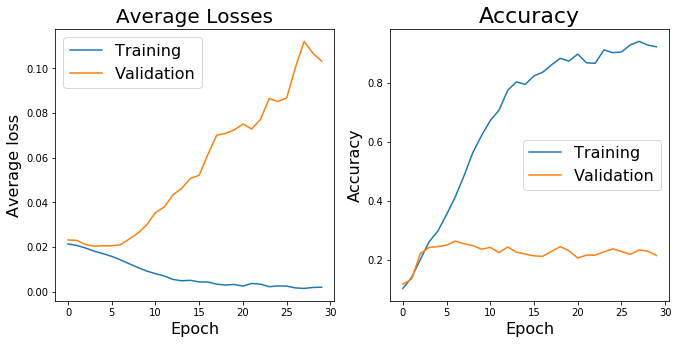

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(11,5))

ax = axs[0]
ax.set_title("Average Losses", fontsize=20)
ax.plot(train_loss_history, label="Training")
ax.plot(val_loss_history,   label="Validation")
ax.set_xlabel("Epoch",        fontsize=16)
ax.set_ylabel("Average loss", fontsize=16)
ax.legend(loc="best",         fontsize=16)

ax = axs[1]
ax.set_title("Accuracy", fontsize=22)
ax.plot(train_acc_history, label="Training")
ax.plot(val_acc_history,   label="Validation")
ax.set_xlabel("Epoch",        fontsize=16)
ax.set_ylabel("Accuracy",     fontsize=16)
ax.legend(loc="best",         fontsize=16)

In [4]:
def get_dataloader(transform):
    """
    Returns dataloader for AnimalDataset given input transform, with batch size 1.
    """
    dataset = AnimalDataset(os.path.join('.', 'data', 'val'),  classes, transform=transform)
    return DataLoader(dataset, batch_size=1, shuffle=False)

### Data Augmentation

CNNs often require a large amount of image data in order to generalize well. A useful method for increasing the size of your dataset is called data augmentation.

If you have an image of a sheep, you can shift it by a few pixels, rotate it, or change its contrast, and you'll still see an image of a sheep. So, you can **increase the size of your dataset** by applying small changes like these to your images while keeping the same labels.

### <font color='red'>TODO [code]</font>:
Implement the data augmentation transforms in `student.py`. You can visualize them using the cells below. When you're ready, you can save the resulting image to include in your writeup. Feel free to use anything in scipy, cv2, numpy, or skimage. However, **do not** use functions from torch or torchvision for this data augmentation step!

### <font color='red'>TODO [writeup] 2b</font>:
Include the plot from below with your images for data augmentation in the writeup. For a sample of correct behavior, look at the provided `data_augmentation_sample.png`. Note that you won't match it exactly since many values are randomized, but you can still see if your code is doing what you expect.

NameError: name 'AnimalDataset' is not defined

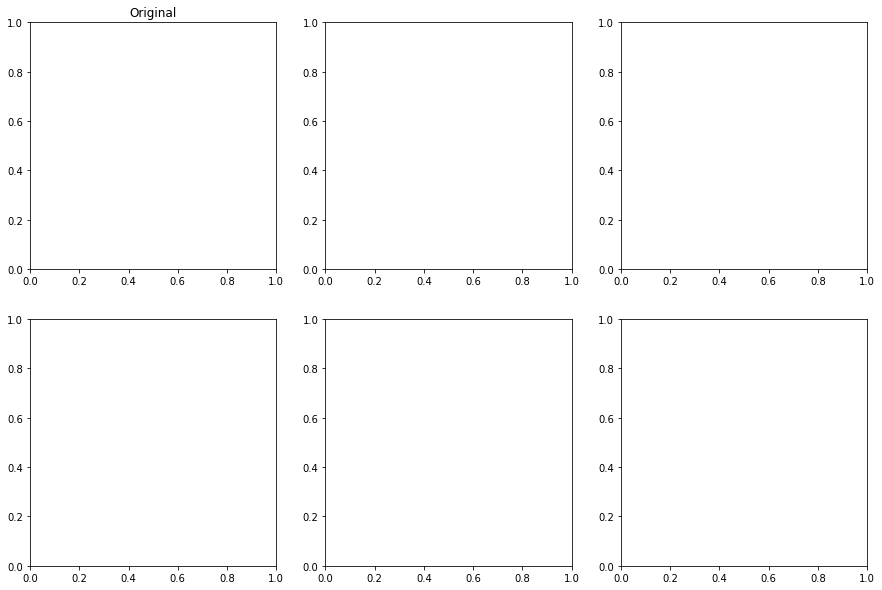

In [3]:
%aimport student

# Define display function to convert image to correct format
to_pil = transforms.ToPILImage()
convert = lambda image: to_pil(image.squeeze())

fig, axs = plt.subplots(2, 3, figsize=(15,10))

ax = axs[0,0]
ax.set_title("Original")
transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor()
        ])
img, label = next(iter(get_dataloader(transform)))
ax.imshow(convert(img))

ax = axs[0,1]
ax.set_title("Constrast")
transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            student.Contrast(min_contrast=0.3, max_contrast=0.9)
        ])
img, label = next(iter(get_dataloader(transform)))
ax.imshow(convert(img))

ax = axs[0,2]
ax.set_title("Shift")
transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            student.Shift(max_shift=5)
        ])
img, label = next(iter(get_dataloader(transform)))
ax.imshow(convert(img))

ax = axs[1,0]
ax.set_title("Rotate")
transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            student.Rotate(max_angle=10)
        ])
img, label = next(iter(get_dataloader(transform)))
ax.imshow(convert(img))

ax = axs[1,1]
ax.set_title("Flip")
transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            student.HorizontalFlip(p=1)
        ])
img, label = next(iter(get_dataloader(transform)))
ax.imshow(convert(img))


ax = axs[1,2]
ax.set_title("Combination")
transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            student.Contrast(min_contrast=0.3, max_contrast=0.9),
            student.Shift(max_shift=5),
            student.Rotate(max_angle=10),
            student.HorizontalFlip(p=0.5),
        ])
img, label = next(iter(get_dataloader(transform)))
ax.imshow(convert(img))


# Part 3: Building a better model

Now, it's your turn to build a model. You'll submit your predictions to the Kaggle competition. Your goal: beat the instructor model, while keeping model file size below 5 MB (don't worry, the instructor model follows this restriction too). A few things you can try:
- include data augmentation methods in your transform
- add pooling
- adjust hyperparameters (e.g. batch size, learning rate)
- adjust number of epochs


### <font color='red'>TODO [code]</font>:
In `student.py`, define your own `AnimalStudentNet` model architecture and transform pipeline. We will be running your `model_train` with your `AnimalStudentNet` as well as `get_student_settings` when grading to check consistency with what you submit to Kaggle. Please make sure you follow the following restrictions when building your network. 
#### Restrictions ####
* Model must be below 5 MB
* You may not use pretrained models or model architectures from the internet. We are expecting you to build one from scratch. That being said, you may take inspirtation from model architectures found online or in research but you must implement them from scratch and explain your decisions. 
* You may not use any other dataset than the one provided in the assignment. 
* You may not use data augmentation functions built into torch. Feel free to use your own or define new ones. 
* You may not hand-label the test set. 
* You may not share models between groups. 

### <font color='red'>TODO [writeup] 3</font>:
Include the plots showing your model's loss and accuracy history. Discuss your decisions for your model architecture, as well as `get_student_settings` if you changed the parameters from the baseline. What worked and what didn't? What might be some reasons why?


In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib inline
%aimport student
# Imports

import numpy as np
import sys
import os
from skimage import io
from datetime import datetime

import matplotlib
from matplotlib import pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets


# Constants
classes = [
     'bighorn-sheep',
     'bison',
     'black-stork',
     'brown-bear',
     'bullfrog',
     'camel',
     'gazelle',
     'golden-retriever',
     'goldfish',
     'ladybug',
     'lion',
     'orangutan',
     'penguin',
     'persian-cat',
     'pig',
     'puma'
]

class AnimalDataset(Dataset):
    def __init__(self, root_dir, classes, transform=None):
        """
        Args:
            root_dir (string):
                Directory with all the images.
                Of the form:
                root_dir/
                    <class_XX>/
                        <XXXX>.JPEG
                        ...
                    <class_XX>/
                        <XXXX>.JPEG
                        ...
                where <class_XX> is replaced with the class name, and <XXXX>.JPEG
                are the images. Must be .JPEG extension.
                
            classes (list of strings): list of class names, same as names of
                subfolders under root_dir
                
            transform (callable, optional): Optional transform to be applied
                on a sample.
                
        """
        self.root_dir = root_dir
        self.classes = classes
        self.transform = transform

        self.raw_data = []
        for i, cl in enumerate(self.classes):
            for root, directory, files in os.walk(os.path.join(root_dir, cl)):
                for file in files:
                    if '.JPEG' in file:
                        self.raw_data.append((os.path.join(root, file), i))

    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self, idx):
        if type(idx) == torch.Tensor:
            idx = idx.item()
        
        image_path, label = (self.raw_data[idx])
        image = io.imread(image_path)
        image = self.transform(image)
        label = torch.tensor([label], dtype=torch.long)
        return image, label

def log_progress(curr_batch, batch_size, curr_epoch, total_epochs, dataloader):
    """
    Prints message logging progress through training.
    """
    progress = float(curr_batch + 1)/(float(len(dataloader.dataset)) / batch_size)
    log = "EPOCH [{}/{}].Progress: {} % ".format(
        curr_epoch + 1, total_epochs, round(progress * 100, 2))
    sys.stdout.write("\r" + log)
    sys.stdout.flush()

def get_dataloader(transform):
    """
    Returns dataloader for AnimalDataset given input transform, with batch size 1.
    """
    dataset = AnimalDataset(os.path.join('.', 'data', 'val'),  classes, transform=transform)
    return DataLoader(dataset, batch_size=1, shuffle=False)

In [2]:
%aimport student

net = student.AnimalStudentNet()
transform, batch_size, epochs, criterion, optimizer = student.get_student_settings(net)

for layer in net.children():
    print(layer)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=16, bias=True)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BatchNorm2d(64, eps=1e-05, momentum=0

In [3]:
from torchsummary import summary
summary(net, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
       BatchNorm2d-4           [-1, 64, 64, 64]             128
              ReLU-5           [-1, 64, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          36,928
       BatchNorm2d-7           [-1, 64, 64, 64]             128
              ReLU-8           [-1, 64, 64, 64]               0
         MaxPool2d-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          36,928
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          36,928
      BatchNorm2d-14           [-1, 64,

In [4]:
train_dataset = AnimalDataset(os.path.join('.', 'data', 'train'),classes, transform=transform)
val_dataset   = AnimalDataset(os.path.join('.', 'data', 'val'),  classes, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=True)

In [5]:
%aimport student

# Keep track of average losses, training accuracy and validation accuracy for each epoch
train_loss_history = np.zeros(epochs)
train_acc_history  = np.zeros(epochs)
val_loss_history   = np.zeros(epochs)
val_acc_history    = np.zeros(epochs)

start_time = datetime.now()

for epoch in range(epochs):
    
     # ============================ Training ==============================
    print("Training...")
    
    # Place network in training mode
    net.train()
    
    # Initialize running epoch loss and number correctly classified
    running_loss   = 0.0
    num_correct    = 0.0
    total_images   = 0.0
    
    for batch_num, (inputs, labels) in enumerate(train_dataloader):
        # [inputs] and [labels] is one batch of images and their classes

        log_progress(batch_num, batch_size, epoch, epochs, train_dataloader)
        
        #  ***** Function call to student *****
        curr_loss, curr_correct, curr_images = \
            student.model_train(net, inputs, labels, criterion, optimizer)
        running_loss += curr_loss
        num_correct += curr_correct
        total_images += curr_images

    # Update statistics for epoch
    train_loss_history[epoch] = running_loss / total_images
    train_acc_history[epoch]  = float(num_correct)  / float(total_images)
    print("\n Train Avg. Loss: [{}] Acc: {} on {} images\n".format(
          round(train_loss_history[epoch],4), train_acc_history[epoch], total_images) )
    
    # ============================ Validation ==============================
    print("Validating...")
    # Place network in testing mode (won't need to keep track of gradients)
    net.eval()
    
    running_loss   = 0.0
    num_correct    = 0.0
    total_images   = 0.0
    
    for batch_num, (inputs, labels) in enumerate(val_dataloader):
        
        # Propagate batch through network
        outputs  = net(inputs)
                                                 
        # Calculate loss
        loss     = criterion(outputs, labels.squeeze())
                                                 
        # Prediction is class with highest class score
        _, preds = torch.max(outputs, 1)
        
        running_loss  += loss.item()
        num_correct   += torch.sum(preds == labels.data.reshape(-1))
        total_images  += labels.data.numpy().size
        
    # Update statistics for validation data
    val_loss_history[epoch] = running_loss / total_images
    val_acc_history[epoch]  = float(num_correct)  / float(total_images) 
    print("Val Avg. Loss: [{}] Acc: {} on {} images\n".format(
        round(val_loss_history[epoch],4), val_acc_history[epoch], total_images))
    
print("Time Elapsed: {} seconds".format(
    (datetime.now() - start_time).total_seconds()))

Training...
EPOCH [1/4].Progress: 100.0 % 
 Train Avg. Loss: [0.0834] Acc: 0.192375 on 8000.0 images

Validating...
Val Avg. Loss: [0.0807] Acc: 0.26125 on 800.0 images

Training...
EPOCH [2/4].Progress: 100.0 % 
 Train Avg. Loss: [0.0776] Acc: 0.353625 on 8000.0 images

Validating...
Val Avg. Loss: [0.0764] Acc: 0.35625 on 800.0 images

Training...
EPOCH [3/4].Progress: 100.0 % 
 Train Avg. Loss: [0.0744] Acc: 0.4505 on 8000.0 images

Validating...
Val Avg. Loss: [0.0745] Acc: 0.42 on 800.0 images

Training...
EPOCH [4/4].Progress: 100.0 % 
 Train Avg. Loss: [0.0724] Acc: 0.494 on 8000.0 images

Validating...
Val Avg. Loss: [0.0729] Acc: 0.45625 on 800.0 images

Time Elapsed: 1610.046313 seconds


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(11,5))

ax = axs[0]
ax.set_title("Student Avg Losses", fontsize=20)
ax.plot(train_loss_history, label="Training")
ax.plot(val_loss_history,   label="Validation")
ax.set_xlabel("Epoch",        fontsize=16)
ax.set_ylabel("Average loss", fontsize=16)
ax.legend(loc="best",         fontsize=16)

ax = axs[1]
ax.set_title("Student Accuracy", fontsize=22)
ax.plot(train_acc_history, label="Training")
ax.plot(val_acc_history,   label="Validation")
ax.set_xlabel("Epoch",        fontsize=16)
ax.set_ylabel("Accuracy",     fontsize=16)
ax.legend(loc="best",         fontsize=16)

#### Saving the Model####
If you would like to save your model after you have trained it for later use (like in the kaggle notebook). Please use torch.save as below. This will save your model as 'my_model_name.pth' in the models folder. Feel free to modify the name. 

In [ ]:
torch.save(net.state_dict(), os.path.join('.','models','my_model_name.pth'))

# Part 4: Adversarial Examples

Convolutional neural networks are extremely powerful models when it comes to images; today, they are used extensively in drug discovery, disease detection, self-driving cars, and more. However, they are far from perfect. Turns out, these networks can be tricked very easily, using the concept of _adversarial examples_. In this part, we will generate adversarial examples to trick our own model.

#### High-Level Overview
We start with an image, $I$, that is classified correctly as class $C$. Our objective is to **manipulate the image** $I$ by adding **small changes** to it which would make the network **misclassify** the image. We can do so by observing the gradients produced within the model. Essentially, we find the direction in which we must change each input image pixel to maximize the loss, and we give the image's pixels a slight nudge in that direction. We get a new image, $I_{perturbed}$, that the network misclassifies.

The scary part is that $I_{perturbed}$ contains tiny, imperceptible changes relative to $I$; to the human eye, $I$ and $I_{perturbed}$ visually look like the same image. Yet, the model perceives these two images completely differently.


#### Implementation

Below is a loop that loads the baseline model and sends images through it one by one. When it classifies an image correctly, you will create an adversarial image and see if you can fool the network into misclassifying it.


For each correctly classified image, we need the gradient of the loss with respect to the image: $G = \frac{\partial_{loss}}{\partial_{I}}$. We use this to create a matrix $\alpha$ (defined below) of perturbations and add it to the original image:

$$I_{perturbed} = I + \alpha$$

$\alpha$ and $G$ have the same dimensions. $\alpha$ is a matrix where the absolute value of each element is a small $\epsilon$, yet the _sign_ (positive or negative) of $\alpha[i,j]$ is equal to the _sign_ of $G[i,j]$. This makes sense: if the gradient value at some pixel is  negative, then you want to follow that negative slope and add negative noise value to your original image.


### **<font color="red">TODO [code]: </font>**
Complete the `get_adversarial` in `student.py`. Run the cells below. Your function should get **at least 85% of adversarial images misclassified** with an `epsilon=0.02`.

### **<font color="red">TODO [writeup] 4: </font>**
Include 3 adversarial image plots from the cells below in your writeup: one with `epsilon=0.005`, one with `epsilon=0.02`, and one with `epsilon=0.15`. As you increase epsilon, what happens to the misclassification rate? Why?

In [ ]:
%aimport student

# Load pretrained baseline model
net          = student.AnimalBaselineNet()
weights_path = os.path.join('.', 'models', 'baseline.pth')
net.load_state_dict(torch.load(weights_path, map_location="cpu"))

# Specify parameters for forward pass
# Don't normalize images for purpose of visualization
transform = transforms.Compose([
            transforms.ToTensor()
        ])
val_dataset    = AnimalDataset(os.path.join('.', 'data', 'val'),  classes, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)

criterion = nn.CrossEntropyLoss()
epsilon = 0.02

original_imgs      = []
original_preds     = []

adversarial_imgs   = []
adversarial_preds  = []
adversarial_noises = []


for i, (img, label) in enumerate(val_dataloader):
    
    # Set image tensor so gradient is calculated
    img.requires_grad = True
    
    output = net(img)

    init_pred = output.max(1, keepdim=True)[1]
    
    if init_pred == label:
        # Image classified correctly; generate adversarial image
        perturbed_img, noise = student.get_adversarial(img, output, label[0], net, criterion, epsilon)
    
        adversarial_output = net(perturbed_img)
        adversarial_pred   = adversarial_output.max(1, keepdim=True)[1]

        original_imgs.append(to_pil(img.squeeze()))
        original_preds.append(init_pred)
        adversarial_imgs.append(to_pil(perturbed_img.squeeze()))
        adversarial_preds.append(adversarial_pred)
        adversarial_noises.append(to_pil(noise.squeeze()))
    


print("Out of total {} images generated, {} % of adversarial images misclassified".format(
    len(original_imgs),
    round((torch.sum(torch.Tensor(original_preds) != torch.Tensor(adversarial_preds)).item())
        / len(original_imgs) * 100., 4)))



In [ ]:
num_desired_adversarial = 4

fig, axs = plt.subplots(num_desired_adversarial, 3, figsize=(10,3*num_desired_adversarial))
matplotlib.rcParams.update({'font.size': 14})


for i in range(num_desired_adversarial):
    ax = axs[i,0]
    ax.set_title('Original: {}'.format(classes[original_preds[i]]))
    ax.imshow(original_imgs[i])
    
    ax = axs[i,1]
    ax.set_title('Adversarial Noise')
    ax.imshow(adversarial_noises[i])
    
    ax = axs[i,2]
    ax.set_title('Adversarial: {}'.format(classes[adversarial_preds[i]]))
    ax.imshow(adversarial_imgs[i])
    
plt.tight_layout()
plt.show()
    

#### On a positive note...
While this may seem like a dealbreaker for convolutional neural networks, a lot of research is being done on the topic of adversarial examples. People have been finding ways to make our networks more robust to adversarial attacks, and there's also a whole class of networks called Generative Adversarial Networks (GANs) that rely on the concept of adversarial actors to generate new, synthetic data for a given dataset.

If you're interested in learning more about any of the topics in this project, please post on Piazza or ask in office hours and we'd be happy to share more resources :)


### **<font color="red">TODO [writeup] Feedback (not graded, but very appreciated): </font>**
If you have any feedback on this assignment as a whole, please include! It is a new assignment, so we would love to hear your thoughts on it and how we can make it better next time around. Thanks!